# The F-test for Comparing Multiple Classifiers

The method of using the F-test for comparing two classifiers is somewhat loosely based on Looney's work.

Thus method can be used to compare **two** or **more** classifiers. And, in the context of the F-test, our null hypothesis is that there that there is no difference between the classification accuracies

A null **hypothesis** is a type of hypothesis used in statistics that proposes that there is no difference between certain characteristics of a population.
In this case, we are trying to prove that there is no difference between the classification accuracies of the multiple classifiers, therefore, proving the null hypothesis.

## Data Preprocessing

### Import dependencies and classifiers

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
import random
import scipy.stats

#Classifiers
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Dataset
from mlxtend.data import iris_data

### Load data

For this work, we use the Iris Dataset with **150 examples** and **3 classes** for classification. This is a very common dataset to be used in small testing.
We only kept **2 features** so we could predict from them.

Since these scores are based off a normal test/train split of the data, we shuffle our data, and then **split 80% for training and 20% for testing**.

We used k-fold in previous iterations but the recommended methods for comparing model and algorithm is one of the two:  
 - **Combined 5x2cv F test**
 - **Nested cross validation**
    
And therefore, we use the combined 5x2cv F test in a future cell, ahead.

In [42]:
#Load Data
X, y = iris_data()
X = X[:,[0, 2]]     #Easy to visualize

#Divide data into Train and Validation
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)
X, y = np.array(list(X)), np.array(list(y))

split_amount = int(len(X)*0.2)

X_test = X[:split_amount]
X_train = X[split_amount:]

y_test = y[:split_amount]
y_train = y[split_amount:]

## Initialization of the classifiers

To test the different classifiers, we assign each one of the following to a variable and then compare them visually, to better visualize the regions they classify. Since the data is simple to observe and only classifies into one of 3 classes, the visualization of the result is easy to assess.  

These are the five classifiers used:
 - **SVM Linear**
 - **SVM RBF**
 - **Linear Discriminant**
 - **KNN**
 - **Perceptron**

In [43]:
# Initializing Classifiers
clf1 = SVC(kernel='linear')
clf2 = SVC(kernel='rbf')
clf3 = LinearDiscriminantAnalysis()
clf4 = KNeighborsClassifier(n_neighbors=3)
clf5 = Perceptron()

labels = ['SVM linear',
          'SVM RBF',
          'LinearDiscriminantAnalysis',
          'KNN',
          'Perceptron']

## Plotting the data

To have a better understanding on the similarity of the models we included a plot on the several trained models

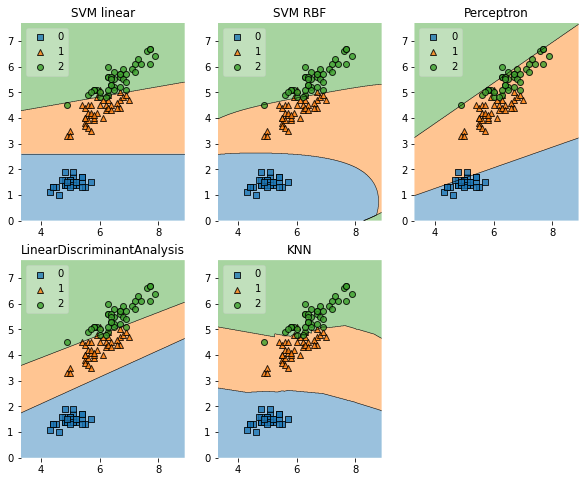

In [44]:
# Plotting Decision Regions
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10, 8))
preds = []
                       
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5],
                         labels,
                         [(0,0), (0,1), (1,0), (1,1), (0,2)]):
                       
    clf.fit(X_train, y_train) #FIT model
    preds.append(np.array(clf.predict(X_test))) #MakePredictions

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()

As we can observe from the plots, apart from the perceptron, these models have **high accuracy** and can accurately predict the regions of said classes, even though the dataset isn't very large.

The **perceptron** fails to classify the majority of the examples correctly.

## F-Test

An F-test is a statistical test in which the test statistic has an F-distribution under the null hypothesis.  
It is most often used when comparing statistical models that have been fitted to a data set.  

Procedure:  
{C1, . . . , CM} is a set of classifiers which have all been tested on the same dataset.   
- m: number of classifiers  
- n: number of examples in the test set

F statistic is distributed according to an F distribution
with (M − 1) and (M − 1) × n degrees of freedom.

We start by defining ACCavg as the average of the accuracies of the different models.
![ACCavg](pictures/1.png)

The sum of squares of the classifiers is then computed as:  
Where Gj is the proportion of the n examples classified correctly by classifier j.
![ACCavg](pictures/2.png)

The sum of squares for the objects is calculated as follows:  
Where Mj is the number of classifiers out of M that correctly classified object xj ∈ Xn, where
Xn = {x1, ...xn} is the test dataset on which the classifiers are tested on.
![ACCavg](pictures/3.png)

Total sum of squares:
![ACCavg](pictures/4.png)

Sum of squares for the classification–object interaction:
![ACCavg](pictures/5.png)

Mean SSA:
![ACCavg](pictures/6.png)

Mean SSAB:
![ACCavg](pictures/7.png)

We can now calculate the F-value as:
![ACCavg](pictures/8.png)

With the F-value, we can then look up the p-value from an F-distribution table for the
corresponding degrees of freedom or obtain it computationally from a cumulative F-distribution
function.


In [45]:
def f_test(y_true, *y_models):
    n = len(y_true)
    m = len(y_models)

    avgACC = sum([accuracy_score(y_true, y) for y in y_models]) / m

    gjSum = sum([((y_true == ypred).sum() / n)**2 for ypred in y_models])
    ssa = n * gjSum - n * m * avgACC**2

    mjSum = 0
    for i in range(n):
        y = y_true[i]
        count = 0
        for ypred in y_models:
            if y == ypred[i]:
                count += 1
        mjSum += count**2
    ssb = 1/m * mjSum - m * n * avgACC**2

    sst = m * n * avgACC*(1-avgACC)

    ssab = sst - ssa - ssb

    msa = ssa / (m-1)

    msab = ssab / ((m-1) * (n-1))

    f = msa / msab

    degrees_of_freedom_1 = m - 1
    degrees_of_freedom_2 = degrees_of_freedom_1 * n

    p_value = scipy.stats.f.sf(f, degrees_of_freedom_1, degrees_of_freedom_2)

    return f, p_value

Assuming a significance level α=0.05, we can test the null hypothesis:  
**There is no difference between the classification accuracies of the models**.

If the p-value is smaller than α, we can reject the null hypothesis and conclude that there is a difference between the classification accuracies.

In [46]:
def nullHyp(p_value):
    if p_value < 0.05:   #significance level α=0.05
        print("Rejected the null hypothesys") #there is a difference between the classification accuracies
    else:
        print("Accepted the null hypothesys") #There is no difference between the classification accuracies

## Models evaluation

### Excluding the Perceptron

In [47]:
#TRY WITHOUT PECEPTRON

f, p_value = f_test(y_test, preds[0],preds[1],preds[2],preds[3])
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)
nullHyp(p_value)


F: 1.000
p-value: 0.397
Accepted the null hypothesys


### Including the Perceptron

In [48]:
#TRY WITH PECEPTRON

f, p_value = f_test(y_test, preds[0],preds[1],preds[2],preds[3], preds[4])
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)
nullHyp(p_value)

F: 8.464
p-value: 0.000
Rejected the null hypothesys


As we can see (most of the times), in the comparison between the first 4 classifiers, we accepted the null hypothesys, meaning that there is no important difference between the classification accuracys of the models.

However, when we compare Peceptron as well, which didnt fit the data and has a bad accuracy, we can reject the null hypothesys, meaning that the models have significant difference in classification accuracys.

### Evaluate two models with 5x2cv combined F-test

After computing the F-value, we can then look up the p-value from a F-distribution table for the corresponding degrees of freedom or obtain it computationally from a cumulative F-distribution function. In practice, if we successfully rejected the null hypothesis at a previously chosen significance threshold (0.05), we could perform multiple post hoc pair-wise tests.

So, as we rejected the models evaluation when the **Perceptron** was included, we could evaluate them pair-wise and discover what pair or pairs was the "outlier". Since we already know it is the **Perceptron**, we also performed the 5x2cv combined F-test with the **Perceptron** and the **Linear SVM**

In [49]:
from mlxtend.evaluate import combined_ftest_5x2cv

score1 = clf1.fit(X, y).score(X_test, y_test)
print('Linear SVM accuracy: %.2f%%' % (score1*100))

score2 = clf5.fit(X, y).score(X_test, y_test)
print('Perceptron accuracy: %.2f%%\n' % (score2*100))

# Here we get the values for the whole X and Y, pre-split
f, p = combined_ftest_5x2cv(estimator1=clf1,
                            estimator2=clf5,
                            X=X, y=y,
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)
nullHyp(p)

Linear SVM accuracy: 100.00%
Perceptron accuracy: 70.00%

F statistic: 9.093
p value: 0.013
Rejected the null hypothesys


The 5x2cv combined F test is a procedure for comparing the performance of two models (classifiers or regressors) in which we repeat the splitting of the train/test data 5 times.

In each of the 5 iterations, we fit A and B to the training split and evaluate their performance (pA and pB) on the test split. Then, we rotate the training and test sets (the training set becomes the test set and vice versa) compute the performance again, which results in 2 performance difference measures. Then it is paired with the F-test we discussed above and gives results for the F statistic and P value, which allows us to accept or reject the null hypothesis

### Evaluation analysis

As we can see, the perceptron gives off the worst results, since its accuracy to the testing data is only around 40%, while the others are in the range of 92-97% accuracy